## Setup
First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## MNIST Data

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

There are 70k images, and each image has 784 features. This is because each image is 28 x 28 pixels, and each feature simply represents one pixel's intensity, from 0 (white) to 255 (black).

Saving figure some_digit_plot


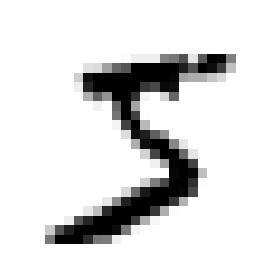

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
save_fig("some_digit_plot")
plt.show()

In [6]:
y[0] # the above output is indeed 5

'5'

In [7]:
# note: that the label is a string, so let's cast y to integer
y = y.astype(np.uint8)

In [56]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [57]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Saving figure more_digits_plot


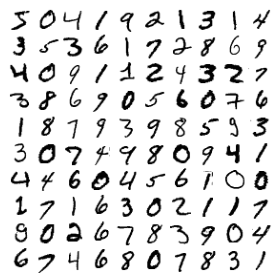

In [58]:
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

The MNIST dataset is already split into a training (first 60000 images) and a test set (last 10000 images)

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Binary Classifier

In [9]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

### Stochastic Gradient Descent (SGD) classifier

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

sgd_clf.predict([some_digit])

array([ True])

In [11]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

Measuring accuracy using cross-validation

In [12]:
# implementing cross-validation
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

/Users/sankalp/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


0.95035
0.96035
0.9604


In [13]:
# a dumb classifier that classifies every single image in the 'not-5' class
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool)

In [14]:
never5_clf = Never5Classifier()
cross_val_score(never5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

It has an accuracy of 90%! This is simply because only about 10% of images are 5s, so the guess if it is not a '5' will always be right 90% of the time.<br>
This is why accuracy is generally not preferred performance measure for classifiers especially when you are dealing with skewed dataset.

#### Confusion Matrix
The general idea is to count the no. of times instances of class A are classified as class B.

In [15]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [16]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

54892 => true negative <br>
687 => false positive<br>
1891 => false negative<br>
3530 => true positive<br>

row represent an <i>actual</i> class, column represents <i>predicted</i> class

A perfect classifier would have non-zero values only on its main diagonal.

In [17]:
y_train_perfect_predictions = y_train_5 # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

In [18]:
from sklearn.metrics import precision_score, recall_score

#### Precision
precision = TP/(TP+FP)

In [19]:
precision_score(y_train_5, y_train_pred)

0.8370879772350012

This implies that when the classifier claims that an image represents a 5, it is correct only 83.70% of the time.

#### Recall
recall = TP/(TP + FN)

In [20]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

It only detects 65.11% of the 5s.

#### F1 Score
The F1 score is the <i>harmonic</i> mean of precision and recall. <br>
Whereas the <i>regular</i> mean treats all values equally, the harmonic mean gives much more weight to low values. As a result, the classifier will only get a higher F1 score if both recall and precision are high.
<br>
F1 = TP/(TP + ((FN+FP)/2))

In [21]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

The F1 score favours classifiers that have similar precision and recall.<br>
This is not always what you want: in some contexts you mostly care about precision, and in other contexts you really care about recall.
<br><br>
For example, if you train a classifier to detect videos that are safe for kids, you want low recall and high precision. On the other hand, suppose you train a classifier to detect shoplifters in surveillance images, you want high recall and low precision.
<br>
Unfortunately, you can't have it both ways: <b><i>increasing precision reduces recall, and vice versa.</i></b><br><br>
This is called the `precision/recall trade-off'.

#### Precision / recall trade-off

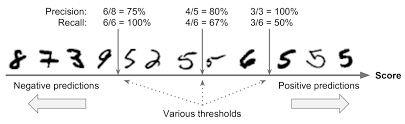
Suppose the decision threshold is positioned at the central arrow (between the two 5s): you will find 4 true positives(actual 5s) on the right of that threshold, and 1 false positive(actually a 6). Therefore with that threshold the precision is 80%(4 out of 5). But out of 6 actual 5s the classifier only detects 4,so the recall is 67%(4 out of 6). If you raise the threshold, the false positive(the 6) becomes a true negative, thereby increasing the precision (upto 100% in this case), but one true positive becomes a false negative, decreasing recall down to 50%.

In [22]:
# decision_function() returns a score for each instance
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [23]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [24]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

How to decide which threshold to use? first use the cross_val_predict() function to get the scores of all instances in the training set, but specify you want to return `decision_scores` instead of predictions:

In [25]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [26]:
# precision_recall_curve() is to compute precision and recall for all possible thresholds:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Saving figure precision_recall_vs_threshold_plot


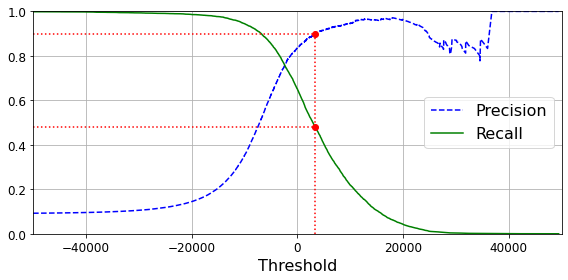

In [27]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")    
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown
    

recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
save_fig("precision_recall_vs_threshold_plot")                                              # Not shown

plt.show()

In [28]:
(y_train_pred == (y_scores > 0)).all()

True

Saving figure precision_vs_recall_plot


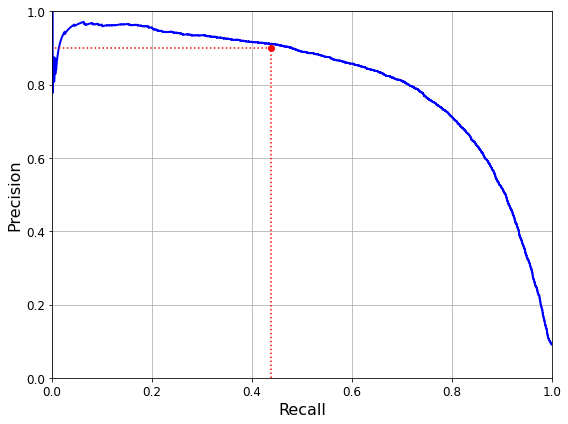

In [29]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel('Recall', fontsize=16)
    plt.ylabel('Precision', fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)
    
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0.4368, 0.4368], [0., 0.9], "r:")
plt.plot([0.4368, 0.], [0.9, 0.9], "r:")
plt.plot([0.4368], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

In [30]:
# to aim for 90% precision, you need to use a threshold of about 8000. 
# to be more precise you can search for the lowest threshold that gives you at least 90% precision
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [31]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
y_train_pred_90

array([False, False, False, ...,  True, False, False])

In [32]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [33]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

It is fairly easy to create a classifier with any precision you want; just set a high enough threshold.<br>
<i>But a high-precision classifier is not useful if its recall is too low!</i>

#### The ROC Curve

The ROC curve is similar to the precision/recall curve, but instead of plotting precision vs recall, the ROC curve plots the <i>true positive rate</i> (another name for recall) against the false positive rate (FPR).<br>
The FPR is the ratio of negative instances that are incorrectly classified as positive. It is equal to 1 - the <i>true negative rate</i> (TNR), which is the ratio of negative instances that are correctly classified as negative. The TNR is also called <i>specificity</i>. Hence, the ROC curve plots sentivity (recall) vs 1 - specificity.

In [34]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Saving figure roc_curve_plot


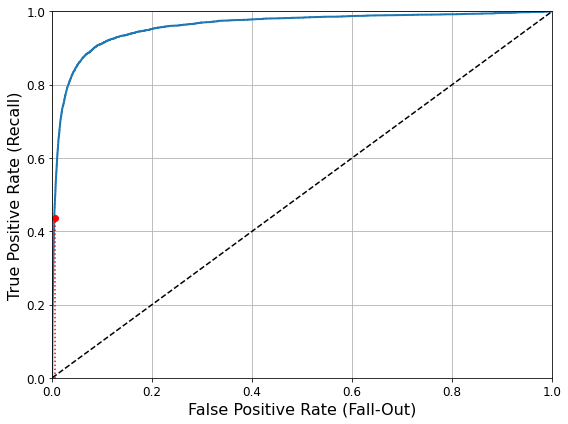

In [35]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown
    
plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
save_fig("roc_curve_plot")                         # Not shown
plt.show()

One way to compare classifiers is to measure the area under the curve (AUC). A perfect classifier will have ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5 

In [36]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

#### When to use ROC or PR curve?
Since both are so similar, as a rule of thumb, you must prefer PR curve when you care more about the false positives than the false negatives. 

### RandomForestClassifier
Compare its ROC curve and ROC AUC score with SGD classifier.

In [37]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
# random forest does not have decision_function()
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba') 

y_score_forest = y_probas_forest[:, 1] # score = proba of positive values
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_score_forest)

Saving figure roc_curve_comparison_plot


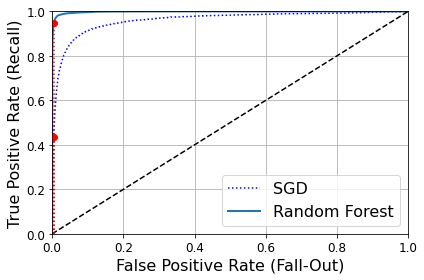

In [38]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right')
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:")
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")
plt.plot([4.837e-3], [0.4368], "ro")
plt.plot([4.837e-3, 4.837e-3], [0., 0.9487], "r:")
plt.plot([4.837e-3], [0.9487], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

Comaparing the ROC curves: <i>the Random Forest classifier is superior to the SGD classifier because its ROC curve is much closer to the top-left corner, and it has a greater AUC.</i>

In [39]:
roc_auc_score(y_train_5, y_score_forest)

0.9983436731328145

In [40]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)

# precision score
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [41]:
# recall score
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

## Multiclass Classification

The SGD classifiers, Random forest classifiers and Naive Bayes classifiers are capable of handling multiple classes natively. <br>
Logistic Regression and SVM classifiers are strictly binary classifiers.<br>

However, there are various ways that you can perform multiclass classifications with multiple binary classifications.<br><br> One way is to train 10 binary classifiers, one for each digit (a 0-detector, 1-detector, ... and so on) <br>
Then when you want to classify an image, you get the decision score from each classifier for that image and you select the class whose classifier outputs the highest score.<br>
This is called the <i>one-versus-the-rest (OvR)</i> strategy.

Another strategy is to train a binary classifier for every single pair of digits: one to distinguish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on.<br>
This is called <i>one-versus-one (OvO)</i> strategy.<br><br>
If there are N classes,you need to train N x ( N -1 ) / 2 classifiers. For the MNIST problem, this means training 45 binary classifiers!

Some algorithms (such as SVM classifiers) scale poorly wiht the size of training set. For these algorithms OvO is preferred because it is faster to train many classifiers on small training sets than to train few classifiers on large training sets.<br>
For most binary classification algorithms, OvR is preferred.

In [42]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

Under the hood, SVM used OvO strategy: it trained 45 binary classifiers, got their decision scores for the image, and selected the class that won most of the duels.

In [43]:
# decision scores
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [44]:
np.argmax(some_digit_scores)

5

In [45]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [46]:
svm_clf.classes_[5]

5

In [47]:
# training an SGD classifier 
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

The decision_function() method returns one value per class.

In [48]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [49]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

Scaling the inputs increases the accuracy

In [50]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

## Error Analysis

In [51]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)

conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

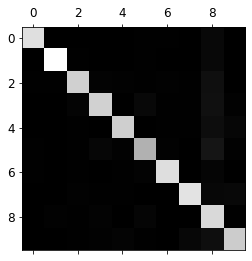

In [52]:
# an image representation of the confusion matrix
plt.matshow(conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

The confusion matrix looks good, since most of the images are on the main diagonal, which means they were classified correctly.

In [53]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

Filling the diagonals with zeros to keep only the errors

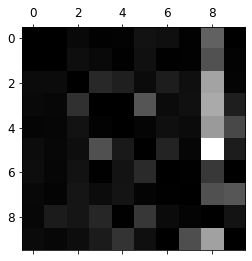

In [54]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

Saving figure error_analysis_digits_plot


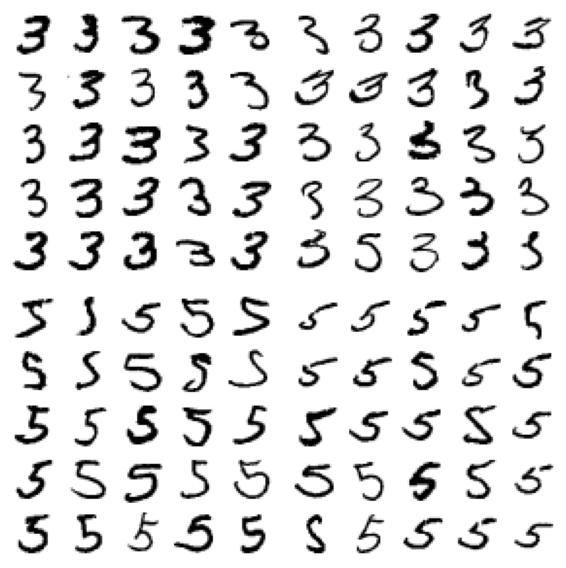

In [59]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()

## Multilabel Classification
Until now each instance was assigned a single class. In some cases we may want our classifier to output multiple classes for each instance. <br><br>
The below code creates a multilabel array containing two labels for each digit image: the first indicates whether or not a digit is large (i.e 7,8 or 9), and the second indicates whether or not it is odd.

In [60]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >- 7)
y_train_odd = (y_train % 2 == 1)

y_multilabel = np.c_[y_train_large, y_train_odd]

In [61]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

knn_clf.predict([some_digit])

array([[ True,  True]])

There are many ways to evaluate a multilabel classifier. One approach is to calculate the F1 score for each individual label, then simply compute the average score.

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)

f1_score(y_multilabel, y_train_knn_pred, average='macro')
# this assume that all labels are equally important. 
# set average='weighted' if any targeted label has more instances

## Multioutput Classification

In [ ]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test

In [ ]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig("noisy_digit_example_plot")
plt.show()

In [ ]:
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)
plot_digit(clean_digit)
save_fig("cleaned_digit_example_plot")